# Export of DL models

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


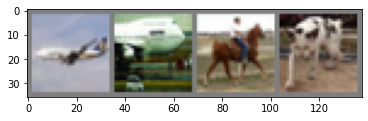

plane plane horse cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
net = net.to(device)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.211 [1,  4000] loss: 1.885 [1,  6000] loss: 1.682 [1,  8000] loss: 1.585 [1, 10000] loss: 1.521 [1, 12000] loss: 1.459 [2,  2000] loss: 1.403 [2,  4000] loss: 1.381 [2,  6000] loss: 1.330 [2,  8000] loss: 1.291 [2, 10000] loss: 1.302 [2, 12000] loss: 1.261 [3,  2000] loss: 1.216 [3,  4000] loss: 1.221 [3,  6000] loss: 1.198 [3,  8000] loss: 1.199 [3, 10000] loss: 1.176 [3, 12000] loss: 1.156 [4,  2000] loss: 1.083 [4,  4000] loss: 1.101 [4,  6000] loss: 1.106 [4,  8000] loss: 1.116 [4, 10000] loss: 1.107 [4, 12000] loss: 1.111 [5,  2000] loss: 1.009 [5,  4000] loss: 1.037 [5,  6000] loss: 1.036 [5,  8000] loss: 1.037 [5, 10000] loss: 1.039 [5, 12000] loss: 1.055 [6,  2000] loss: 0.978 [6,  4000] loss: 0.960 [6,  6000] loss: 0.981 [6,  8000] loss: 0.985 [6, 10000] loss: 0.987 [6, 12000] loss: 1.012 [7,  2000] loss: 0.920 [7,  4000] loss: 0.911 [7,  6000] loss: 0.922 [7,  8000] loss: 0.947 [7, 10000] loss: 0.950 [7, 12000] loss: 0.967 [8,  2000] loss: 0.873 [8,  4000] 

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [10]:
im = images[0,:,:,:].reshape(1,3,32,32).to(device)

In [11]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

449 µs ± 198 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### ONNX

In [12]:
!pip install onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for onnxruntime from https://files.pythonhosted.org/packages/d6/ee/82f181e561980bc59d53bbf14a32629a27c5c4290cfd193898f0d1933a6d/onnxruntime-1.16.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for onnx from https://files.pythonhosted.org/packages/18/be/758ff7735e35c0ce84725c250a48b69c7cf38ddedcb598848b79c3038f3c/onnx-1.15.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 30.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 98.7 MB/s eta 0:00:00a 0:00:01


In [13]:
import onnxruntime as ort
import onnx

In [14]:
x = torch.randn(batch_size, 3, 32, 32, requires_grad=True).to('cuda')
torch_out = net(x)

In [15]:
torch.onnx.export(net,
                  x,
                  "model.onnx",
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [16]:
onnx_model = onnx.load("model.onnx")

In [17]:
onnx.checker.check_model(onnx_model)

In [18]:
ort_session = ort.InferenceSession("model.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

In [19]:
net_pred = net(im).cpu().detach().numpy()
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(im)}
ort_pred = ort_session.run(None, ort_inputs)[0]
checker = np.testing.assert_allclose(
    net_pred,
    ort_pred,
    rtol=1e-02,
    atol=1e-05,
)

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        # outputs = model_trt(images.to(device))
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(images)}
        outputs = torch.tensor(ort_session.run(None, ort_inputs)[0]).to(device)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [21]:
%%timeit -n 10 -r 10
with torch.no_grad():
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(im)}
    ort_pred = ort_session.run(None, ort_inputs)

142 µs ± 40.6 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### TensorRT

In [22]:
!pip install nvidia-pyindex
!pip install nvidia-tensorrt
!pip install torch-tensorrt==1.4.0 -f https://github.com/pytorch/TensorRT/releases/expanded_assets/1.4.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8418 sha256=05505dd832f5f39930dfeb7dcf3f72b440ee0c6a2b5ce0ad82b4ed73188230d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3ftwno4/wheels/39/63/71/c50214b560fa8c319598c2de3c1616f6d68e1d2c7f17a5e82d
Successfully built nvidia-pyindex
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17283 sha256=a7784c0f3f4251c61a45b96be85061410099e3c95a7f0797504ab26160b41cbe
  Stored in directory: /tmp/pip-ephem-wheel-cache-j4l1zoab/wheels/23/4d/dc/faccb519d6f6d918edc8552c819a0ac7553660286ba8422822
Successfully built tensorrt
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://github.com/pytorch/TensorRT/re

In [23]:
import torch_tensorrt

/home/german/anaconda3/envs/compression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
model_trt = torch_tensorrt.compile(net, inputs=[torch_tensorrt.Input((batch_size, 3, 32, 32), dtype=torch.float32)])

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model_trt(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [29]:
model_trt = model_trt.to("cuda")

In [32]:
im = im.to('cuda')

In [33]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = model_trt(im)

11.6 ms ± 678 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [34]:
!nvidia-smi

Mon Oct 30 16:30:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 545.84       CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    29W / 235W |   1445MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------